In [1]:
%cd /scratch/bruingjde/SNAM2021-code/

from constants import *

/scratch/bruingjde/SNAM2021-code


# Time agnostic

In [3]:
def logistic_regression_I(network: int):
  X = dict()
  for heuristic in ['aa', 'cn', 'jc', 'pa']:
    X[heuristic] = np.load(f'data/{network:02}/features/time_agnostic/{heuristic}.npy')
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000)) # type: ignore
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1]) # type: ignore
  
  return auc

time_agnostic_performance = {
  network: logistic_regression_I(network) for network in network_indices}

# Time aware

In [4]:
def logistic_regression_I_II_III_hypergraph(network: int):
  X = dict()
  # Type I features
  for heuristic in ['aa', 'cn', 'jc', 'pa']:
    X[heuristic] = (
      np.load(f'data/{network:02}/features/time_agnostic/{heuristic}.npy'))
    
  # Type II features
  for time_strategy in time_strategies:
    for nodepair_strategy in nodepair_strategies:
      for aggregation_strategy in ['q0', 'q25', 'q50', 'q75', 'q100', 
                                   'm0', 'm1', 'm2', 'm3']:
        X[(time_strategy, nodepair_strategy, aggregation_strategy)] = (
          np.load(
            f'data/{network:02}/features/time_node/'
            f'{time_strategy}_{nodepair_strategy}_{aggregation_strategy}.npy'))
  # Type III features      
  for heuristic in ['aa', 'cn', 'jc', 'pa']:  
    for time_strategy in time_strategies:
      for aggregation_strategy in ['q0', 'q25', 'q50', 'q75', 'q100', 
                                   'm0', 'm1']:
          X[(heuristic, time_strategy, aggregation_strategy)] = (
            np.load(
              f'data/{network:02}/features/time_edge/'
              f'{heuristic}_{time_strategy}_{aggregation_strategy}.npy'))
    
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000))
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1])
  
  return auc

def logistic_regression_I_II_III_simplegraph(network: int):
  X = dict()
  # Type I
  for heuristic in ['aa', 'cn', 'jc', 'pa']:
    X[heuristic] = (
      np.load(f'data/{network:02}/features/time_agnostic/{heuristic}.npy'))
  # Type II 
  for time_strategy in time_strategies:
    for nodepair_strategy in nodepair_strategies:
        X[(time_strategy, nodepair_strategy)] = (
          np.load(
            f'data/{network:02}/features/time_node/'
            f'{time_strategy}_{nodepair_strategy}.npy'))
  # Type III
  for heuristic in ['aa', 'cn', 'jc', 'pa']:  
    for time_strategy in time_strategies:
      X[(heuristic, time_strategy)] = (
        np.load(
          f'data/{network:02}/features/time_edge/'
          f'{heuristic}_{time_strategy}.npy'))
      
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000))
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1])
  
  return auc

time_aware_performance = {
  network: logistic_regression_I_II_III_hypergraph(network) 
  for network in hypergraph_indices} | {
  network: logistic_regression_I_II_III_simplegraph(network) 
  for network in simplegraph_indices
}

In [16]:
ylabel = 'time aware (AUC)'
xlabel = 'time agnostic (AUC)'

df = pd.concat(
  {
    ylabel: pd.Series(time_aware_performance), 
    xlabel: pd.Series(time_agnostic_performance)
  },
  axis=1)
df['category'] = get_networks()['category']

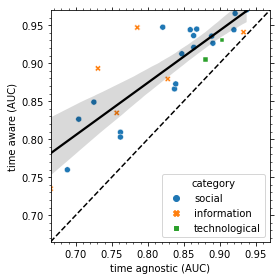

In [19]:
auc_values = df[[ylabel, xlabel]].values.flatten()
lim = (min(auc_values), max(auc_values))

with plt.rc_context(rc):
  sns.scatterplot(data=df, x=xlabel, y=ylabel, 
                  hue='category', style='category')
  sns.regplot(data=df, x=xlabel, y=ylabel, 
              scatter=False, color='black')
  plt.axline((0,0), (1,1), ls='--', c='black')
  plt.xlim(lim)
  plt.ylim(lim)
  ax = plt.gca()
  ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(.01))
  ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(.01))
  plt.tight_layout()
  plt.savefig('code/figures/output/results.pdf')

In [21]:
labels = networks.copy()

In [44]:
node = pd.read_pickle('code/figures/temp.pkl')

In [61]:
merged = pd.concat([df.round(2).drop(columns='category'), labels, node.round(2).drop(columns='category')], axis=1)

In [62]:
print(
  merged[['label', 'category', 'time agnostic (AUC)', 'time aware (AUC)', 'auc (node activity + static features)']].rename(
    columns={'time agnostic (AUC)': 'I (AUC)', 'time aware (AUC)': 'II (AUC)', 'auc (node activity + static features)': 'III (AUC)'}
  ).to_latex(
    index=False,
    caption=('Performance obtained for feature set I-III.'),
    label='table:results',
    escape=False,
    multicolumn=False))

\begin{table}
\centering
\caption{Performance obtained for feature set I-III.}
\label{table:results}
\begin{tabular}{llrrr}
\toprule
label &      category &  I (AUC) &  II (AUC) &  III (AUC) \\
\midrule
 DBLP &        social &     0.70 &      0.83 &       0.79 \\
HepPh &   information &     0.83 &      0.88 &       0.87 \\
Enron &        social &     0.85 &      0.91 &       0.91 \\
 FB-w &        social &     0.76 &      0.81 &       0.79 \\
Condm &        social &     0.69 &      0.76 &       0.73 \\
HepTh &   information &     0.76 &      0.83 &       0.82 \\
 AMin &        social &     0.73 &      0.85 &       0.82 \\
 FB-l &        social &     0.76 &      0.80 &       0.78 \\
D-rep &        social &     0.84 &      0.87 &       0.87 \\
  D-f &        social &     0.89 &      0.93 &       0.92 \\
  D-v &   information &     0.93 &      0.94 &       0.94 \\
 Rado &        social &     0.86 &      0.92 &       0.90 \\
   UC &   information &     0.73 &      0.89 &       0.87 \\
SX-M